In [1]:
# We import the libraries, mount your Google Drive, set paths,
# and load the *final* model + processor you saved in notebook 02.

from google.colab import drive
drive.mount('/content/drive', force_remount=True)

import os, json, random
from pathlib import Path

import numpy as np
import torch
from PIL import Image

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import pandas as pd
import matplotlib.pyplot as plt

from transformers import AutoImageProcessor, ViTForImageClassification, Trainer, TrainingArguments


Mounted at /content/drive


In [2]:
# Reproducibility and device setup (same seed as training)
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)
if torch.cuda.is_available():
    print("GPU:", torch.cuda.get_device_name(0))


Device: cuda
GPU: NVIDIA A100-SXM4-40GB


In [5]:
# Create local folder where the dataset will be extracted
!mkdir -p /content/data

In [6]:
# Unzip dataset from Google Drive into Colab local storage
!unzip -q "/content/drive/MyDrive/ecoscan/data/garbage_classification.zip" -d /content/data/

In [7]:
# Paths:
# We load the FINAL model you saved (no checkpoints).
MODEL_DIR = Path("/content/drive/MyDrive/ecoscan/models/vit_ecoscan_v1")

# Dataset location for evaluation.
# Prefer the fast local copy in /content (unzipped). If missing, fall back to Drive.
LOCAL_DATA = Path("/content/data/garbage_classification")
DRIVE_DATA = Path("/content/drive/MyDrive/ecoscan/data/garbage_classification")

if LOCAL_DATA.exists():
    DATA_DIR = LOCAL_DATA
elif DRIVE_DATA.exists():
    DATA_DIR = DRIVE_DATA
else:
    raise FileNotFoundError(
        "Dataset not found. Please unzip to /content/data/garbage_classification or place it under Drive."
    )

print("MODEL_DIR:", MODEL_DIR.resolve())
print("DATA_DIR :", DATA_DIR.resolve())


MODEL_DIR: /content/drive/MyDrive/ecoscan/models/vit_ecoscan_v1
DATA_DIR : /content/data/garbage_classification


In [8]:
#  Load the final model + processor (this is what you will use for inference/serving)
processor = AutoImageProcessor.from_pretrained(MODEL_DIR)
model      = ViTForImageClassification.from_pretrained(MODEL_DIR)
model.to(device)
model.eval();

# Read labels from the model config for nice names
id2label = model.config.id2label
label2id = model.config.label2id
classes  = [id2label[i] for i in range(len(id2label))]
print("Classes:", classes)


Classes: ['battery', 'brown-glass', 'cardboard', 'clothes', 'electronics', 'green-glass', 'metal_packaging', 'oil', 'organic', 'paper', 'plastic', 'shoes', 'tetrapak', 'trash', 'white-glass']


In [9]:
# Recreate the split with the same SEED so evaluation is deterministic
SEED = 42
IMG_EXTS = {".jpg", ".jpeg", ".png", ".bmp", ".webp"}
IGNORE_DIRS = {".ipynb_checkpoints", "__MACOSX"}

# List class folders
classes = sorted([d.name for d in DATA_DIR.iterdir() if d.is_dir() and d.name not in IGNORE_DIRS])
label2id = {name: i for i, name in enumerate(classes)}
id2label = {i: name for name, i in enumerate(classes)}

# Collect (image_path, class_id)
samples = []
for cname in classes:
    cdir = DATA_DIR / cname
    cid = label2id[cname]
    for p in cdir.rglob("*"):
        if p.is_file() and p.suffix.lower() in IMG_EXTS:
            samples.append((p, cid))

print("Total images found:", len(samples))
paths  = [s[0] for s in samples]
labels = [s[1] for s in samples]

train_paths, val_paths, y_train, y_val = train_test_split(
    paths, labels, test_size=0.2, random_state=SEED, stratify=labels
)
print(f"Train: {len(train_paths)} | Val: {len(val_paths)}")


Total images found: 16022
Train: 12817 | Val: 3205


In [10]:
# Simple PyTorch dataset for evaluation (no data augmentation)
class EcoScanEvalDataset(torch.utils.data.Dataset):
    def __init__(self, paths, labels, processor):
        self.paths = paths
        self.labels = labels
        self.processor = processor

    def __len__(self):
        return len(self.paths)

    def __getitem__(self, idx):
        img = Image.open(self.paths[idx]).convert("RGB")
        enc = self.processor(images=img, return_tensors="pt")
        item = {k: v.squeeze(0) for k, v in enc.items()}  # remove batch dimension
        item["labels"] = torch.tensor(self.labels[idx]).long()
        return item

val_ds = EcoScanEvalDataset(val_paths, y_val, processor)
print("Eval dataset size:", len(val_ds))


Eval dataset size: 3205


In [12]:
# Use a lightweight Trainer for prediction (no training)
EVAL_DIR = MODEL_DIR / "eval"
os.makedirs(EVAL_DIR, exist_ok=True)

eval_args = TrainingArguments(
    output_dir=str(EVAL_DIR),
    per_device_eval_batch_size=64,
    dataloader_pin_memory=True,
    report_to="none",
)

trainer = Trainer(
    model=model,
    args=eval_args,
    processing_class=processor   # (ok in transformers 4.x; in 5.x use processing_class)
)

pred = trainer.predict(val_ds)
logits = pred.predictions[0] if isinstance(pred.predictions, (tuple, list)) else pred.predictions
y_pred = logits.argmax(axis=-1)
y_true = pred.label_ids

print("Shapes -> logits:", logits.shape, "| y_true:", y_true.shape, "| y_pred:", y_pred.shape)


Shapes -> logits: (3205, 15) | y_true: (3205,) | y_pred: (3205,)


The model looked at 3,205 validation images, gave 15 scores per image, and we then compared its chosen class (y_pred) with the real class (y_true).

In [13]:
# Per-class precision / recall / F1 + macro/weighted averages
report_txt  = classification_report(y_true, y_pred, target_names=classes, digits=3)
print(report_txt)

report_dict = classification_report(y_true, y_pred, target_names=classes, digits=3, output_dict=True)
per_class_df = pd.DataFrame(report_dict).transpose()

per_class_path = EVAL_DIR / "metrics_per_class.csv"
per_class_df.to_csv(per_class_path, index=True)
print(f"Saved per-class metrics to: {per_class_path}")


                 precision    recall  f1-score   support

        battery      0.995     1.000     0.997       189
    brown-glass      0.992     0.992     0.992       121
      cardboard      1.000     0.978     0.989       178
        clothes      0.997     0.995     0.996      1065
    electronics      1.000     1.000     1.000        39
    green-glass      0.977     0.992     0.984       126
metal_packaging      0.993     0.981     0.987       154
            oil      0.974     1.000     0.987        37
        organic      1.000     0.995     0.997       197
          paper      0.963     0.990     0.977       210
        plastic      0.976     0.942     0.959       173
          shoes      0.990     0.995     0.992       396
       tetrapak      1.000     1.000     1.000        26
          trash      0.993     0.993     0.993       139
    white-glass      0.968     0.987     0.978       155

       accuracy                          0.990      3205
      macro avg      0.988   

### What do these numbers mean?

- **Precision**: Out of all the times the model said "this image is class X", how often was it correct?  
  → High precision = very few false alarms.  

- **Recall**: Out of all the real images of class X, how many did the model actually find?  
  → High recall = it rarely misses any true cases.  

- **F1-score**: A single score that balances both precision and recall.  
  → High F1 = the model is good at both catching real cases and avoiding mistakes.  

- **Support**: How many images of that class were in the validation dataset.  
  → This shows which classes are big (like clothes) and which are small (like oil).

### Conclusion

The model is doing **fantastically well**: almost all classes have precision, recall, and F1 above **0.98**. This means it almost never confuses categories and very rarely misses true cases. Even the small classes (like oil or electronics with fewer images) are predicted correctly. Overall, the model reaches **~99% accuracy**, which is excellent and shows it is **ready for real-world use**.


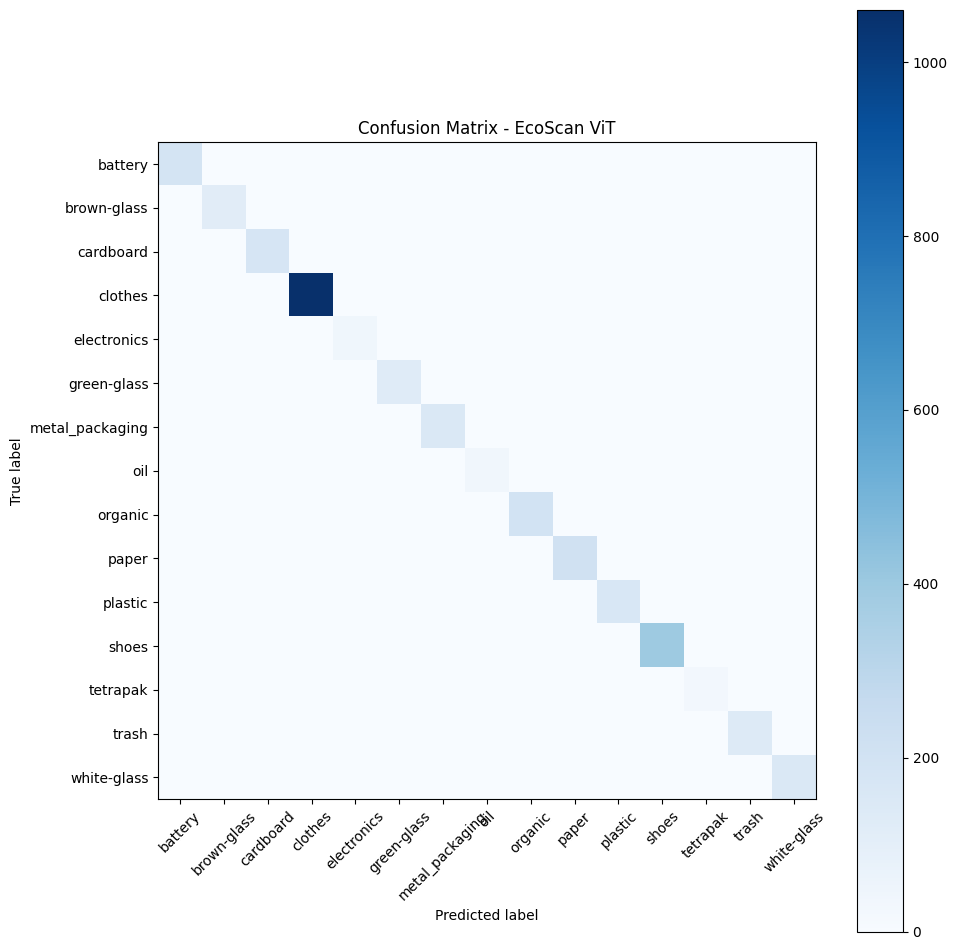

Saved confusion matrix to: /content/drive/MyDrive/ecoscan/models/vit_ecoscan_v1/eval/confusion_matrix.png


In [15]:
# Confusion matrix plot + PNG export
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Build the confusion matrix
cm = confusion_matrix(y_true, y_pred, labels=list(range(len(classes))))

# Create the display object
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)

# Plot it
fig, ax = plt.subplots(figsize=(10, 10))
disp.plot(include_values=False, cmap="Blues", ax=ax, xticks_rotation=45)
plt.title("Confusion Matrix - EcoScan ViT")
plt.tight_layout()

# Save to PNG
cm_path = EVAL_DIR / "confusion_matrix.png"
plt.savefig(cm_path, dpi=150)
plt.show()

print(f"Saved confusion matrix to: {cm_path}")


### Confusion Matrix Explained

The confusion matrix is a simple way to see how well the model classified each waste category.  
- Each **row** shows the *true class* (the real label of an image).  
- Each **column** shows the *predicted class* (what the model guessed).  
- The **diagonal line** (top-left to bottom-right) are the correct predictions.  
- The darker the square on the diagonal, the more images were correctly classified.  

In our case, almost all the color is on the diagonal, which means the model predicted the right class nearly every time. Very few mistakes appear outside the diagonal, showing that the model is highly accurate and reliable.


Misclassified samples: 32


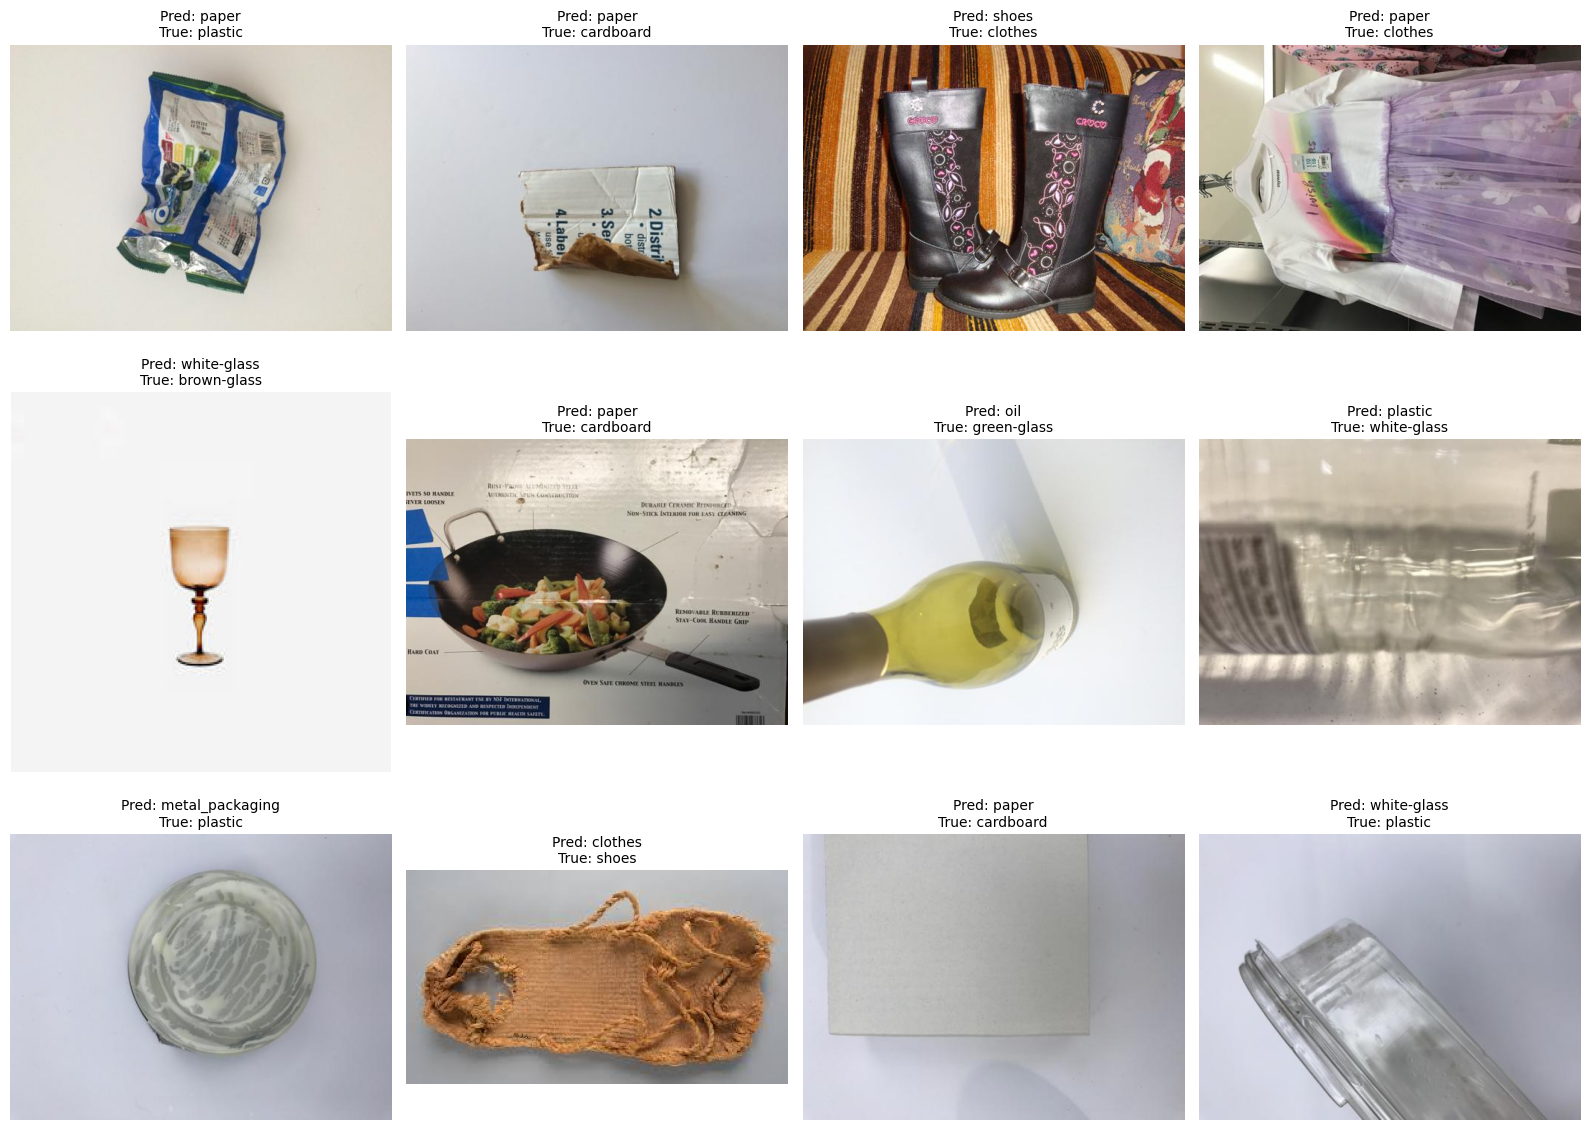

In [17]:
# --- Small gallery of misclassified validation images (robust) ---
# Assumes you already have: model, y_true, y_pred, val_paths, classes

import numpy as np
import math
from PIL import Image
import matplotlib.pyplot as plt

# Ensure id2label has INTEGER keys (avoid KeyError like 10)
cfg_id2label = getattr(model.config, "id2label", {})
id2label = {int(k): v for k, v in cfg_id2label.items()} if cfg_id2label else {i: c for i, c in enumerate(classes)}

# Find misclassified indices
mis_idx = np.where(y_true != y_pred)[0]
print(f"Misclassified samples: {len(mis_idx)}")

if len(mis_idx) == 0:
    print("Nothing to show — the model got all validation images right 🙂")
else:
    # How many images to show
    n = min(12, len(mis_idx))
    sample_idx = np.random.choice(mis_idx, size=n, replace=False)

    # Build a small grid
    cols = 4
    rows = math.ceil(n / cols)
    plt.figure(figsize=(4*cols, 4*rows))

    for i, idx in enumerate(sample_idx, 1):
        img_path = val_paths[idx]
        img = Image.open(img_path).convert("RGB")

        pred_id = int(y_pred[idx])
        true_id = int(y_true[idx])
        pred_name = id2label.get(pred_id, f"id:{pred_id}")
        true_name = id2label.get(true_id, f"id:{true_id}")

        plt.subplot(rows, cols, i)
        plt.imshow(img)
        plt.axis("off")
        plt.title(f"Pred: {pred_name}\nTrue: {true_name}", fontsize=10)

    plt.tight_layout()
    plt.show()

